In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("Urban-ETA-Prediction")\
    .config("spark.sql.warehouse.dir", "/home/khadija/spark-warehouse")  \
    .enableHiveSupport() \
    .getOrCreate()
spark

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/14 21:55:23 WARN Utils: Your hostname, DESKTOP-T1QBIQ7, resolves to a loopback address: 127.0.1.1; using 192.168.100.144 instead (on interface wifi0)
26/01/14 21:55:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/14 21:55:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:

df = spark.read.parquet('data/dataset.parquet')

df.show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

# Analyse Exploratoire des données

In [4]:
# Afficher le schéma (types de colonnes) 

In [5]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



### Statistiqus descriptives 

In [6]:
df.describe().show()

26/01/14 21:55:45 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+------------------+--------------------+-------------------+-------------------+
|summary|          VendorID|   passenger_count|    trip_distance|       RatecodeID|store_and_fwd_flag|     PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|
+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+-------

In [7]:
# Fares and tips
df.select("fare_amount","tip_amount","total_amount").summary().show()

+-------+------------------+------------------+------------------+
|summary|       fare_amount|        tip_amount|      total_amount|
+-------+------------------+------------------+------------------+
|  count|           3475226|           3475226|           3475226|
|   mean| 17.08180276045484|2.9598127862758044|25.611291697280986|
| stddev|463.47291781729996| 3.779681153612477| 463.6584784502166|
|    min|            -900.0|             -86.0|            -901.0|
|    25%|               8.6|               0.0|              15.2|
|    50%|             12.12|              2.45|             19.95|
|    75%|              19.5|              3.93|             27.78|
|    max|         863372.12|             400.0|         863380.37|
+-------+------------------+------------------+------------------+



In [8]:
# Trip distance stats
df.select("trip_distance").summary("min","max","mean","stddev").show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|    min|              0.0|
|    max|        276423.57|
|   mean|5.855126178843539|
| stddev|564.6015996346273|
+-------+-----------------+



### Vérification les valeurs manquantes

In [9]:
from pyspark.sql.functions import col, sum, when, isnan,count
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       0|                   0|                    0|         540149|            0|    540149|            540149|           0|    

### Distribution des variables catégorielles

In [10]:
# Count les Type de paiement
df.groupBy("payment_type").count().show()

# Count store_and_fwd_flag
df.groupBy("store_and_fwd_flag").count().show()


+------------+-------+
|payment_type|  count|
+------------+-------+
|           5|      1|
|           1|2444393|
|           3|  23773|
|           2| 390429|
|           4|  76481|
|           0| 540149|
+------------+-------+



+------------------+-------+
|store_and_fwd_flag|  count|
+------------------+-------+
|                 Y|   7646|
|                 N|2927431|
|              NULL| 540149|
+------------------+-------+



### Détection des valeurs aberrantes

In [11]:
# Trips avec distance <= 0
distance_bas = df.filter(col("trip_distance") <= 0)
print(f"Nombre de trajets avec distance <= 0 : {distance_bas.count()}")
# Trips avec distance très élevée (> 200 miles)
distance_high = df.filter(col("trip_distance") > 200)
print(f"Nombre de trajets avec distance > 200 miles : {distance_high.count()}")


Nombre de trajets avec distance <= 0 : 90893
Nombre de trajets avec distance > 200 miles : 122


In [12]:
print("Aperçu des trajets avec distance <= 0")

distance_bas.select("trip_distance").show(5)

print("Aperçu des trajets avec distance > 200")
distance_high.select("trip_distance").show(5)

Aperçu des trajets avec distance <= 0
+-------------+
|trip_distance|
+-------------+
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
+-------------+
only showing top 5 rows
Aperçu des trajets avec distance > 200
+-------------+
|trip_distance|
+-------------+
|       206.45|
|      1472.37|
|        265.9|
|      1847.61|
|      4020.04|
+-------------+
only showing top 5 rows


In [13]:
# Passagers ≤ 0
passenger_invalid = df.filter(col("passenger_count") <= 0)
print(f"Nombre de trajets avec passagers ≤ 0 : {passenger_invalid.count()}")


Nombre de trajets avec passagers ≤ 0 : 24656


## Ingestion des données brutes (Bronze)

In [18]:
# Créer la base Bronze si elle n'existe pas
spark.sql("CREATE DATABASE IF NOT EXISTS bronze")



26/01/14 22:00:18 WARN ObjectStore: Failed to get database bronze, returning NoSuchObjectException
26/01/14 22:00:18 WARN ObjectStore: Failed to get database bronze, returning NoSuchObjectException
26/01/14 22:00:18 WARN ObjectStore: Failed to get database bronze, returning NoSuchObjectException


DataFrame[]

In [20]:
# Stocker le DataFrame brut (Bronze)
df.write.format("parquet").mode("overwrite").saveAsTable("bronze.bronze_taxi")


26/01/14 22:04:14 WARN HiveExternalCatalog: Hive incompatible types found: timestamp_ntz, timestamp_ntz. Persisting data source table `spark_catalog`.`bronze`.`bronze_taxi` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


In [22]:
# Vérifie que la base bronze existe dans Spark
spark.sql("SHOW DATABASES").show()

# Vérifie que la table bronze_taxi est créée
spark.sql("SHOW TABLES IN bronze").show()



+---------+
|namespace|
+---------+
|   bronze|
|  default|
+---------+

+---------+-----------+-----------+
|namespace|  tableName|isTemporary|
+---------+-----------+-----------+
|   bronze|bronze_taxi|      false|
+---------+-----------+-----------+



# Nettoyage & Feature Engineering

##  Zone Silver

In [23]:
# Charger les données Bronze
silver_df = spark.table("bronze.bronze_taxi")
silver_df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

In [24]:
silver_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



### Nettoyage

#### Supprimer les doublons

In [25]:
silver_df.distinct()

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double, cbd_congestion_fee: double]

#### Suppression des valeurs manquantes

In [26]:

silver_df = silver_df.dropna()


In [27]:
# verification des valeres manquaantes
from pyspark.sql.functions import col, sum, when, isnan,count
silver_df.select([count(when(col(c).isNull(), c)).alias(c) for c in silver_df.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       0|                   0|                    0|              0|            0|         0|                 0|           0|    

#### Filtrage les trajets aberrants

In [28]:
# trajets avec distance > 0 ou et <= 200)
silver_df_fil = silver_df.filter( (silver_df.trip_distance > 0) & (silver_df.trip_distance <= 200) )


In [29]:
 # les passager invalid Passagers ≤ 0
silver_df_fil = silver_df_fil.filter( (silver_df_fil.passenger_count > 0))


In [30]:

# Calculer la durée du trajet en minutes
from pyspark.sql.functions import col, unix_timestamp

silver_df_fil = silver_df_fil.withColumn(
    "trip_duree",
    (unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 60
)
silver_df_fil.select("trip_duree").show(5)

+-----------------+
|       trip_duree|
+-----------------+
|             8.35|
|             2.55|
|             1.95|
|5.566666666666666|
|3.533333333333333|
+-----------------+
only showing top 5 rows


In [31]:
# filtrer Durée > 0 minutes
silver_df_fil = silver_df_fil.filter( (col("trip_duree") > 0) )

In [32]:
# Vérification de toutes les anomalies 
silver_df_fil.filter(
    (col("trip_distance") <= 0) | 
    (col("trip_distance") > 200) | 
    (col("passenger_count") <= 0) | 
    (col("trip_duree") <= 0)
).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|trip_duree|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+----------+
+--------+--------------------+---------------------+---------------+-------------+----------+---

### Feature Engineering

#### Features temporelles

In [33]:
# Convertir les donnes de colonne tpep_pickup_datetime en timestamp
silver_df_new = silver_df_fil.withColumn(
    "tpep_pickup_datetime",
    col("tpep_pickup_datetime").cast("timestamp")
).withColumn(
    "tpep_dropoff_datetime",
    col("tpep_dropoff_datetime").cast("timestamp")
)

silver_df_new.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)
 |-- trip_duree: double (nullable = true)



In [34]:
from pyspark.sql.functions import hour, dayofweek, month

silver_df_new = silver_df_new.withColumn("pickup_hour", hour(col("tpep_pickup_datetime"))) \
                     .withColumn("day_of_week", dayofweek(col("tpep_pickup_datetime"))) \
                     .withColumn("month", month(col("tpep_pickup_datetime")))


In [35]:
silver_df_new.select( "tpep_pickup_datetime", "pickup_hour", "day_of_week", "month").show(10)


+--------------------+-----------+-----------+-----+
|tpep_pickup_datetime|pickup_hour|day_of_week|month|
+--------------------+-----------+-----------+-----+
| 2025-01-01 00:18:38|          0|          4|    1|
| 2025-01-01 00:32:40|          0|          4|    1|
| 2025-01-01 00:44:04|          0|          4|    1|
| 2025-01-01 00:14:27|          0|          4|    1|
| 2025-01-01 00:21:34|          0|          4|    1|
| 2025-01-01 00:48:24|          0|          4|    1|
| 2025-01-01 00:00:02|          0|          4|    1|
| 2025-01-01 00:20:28|          0|          4|    1|
| 2025-01-01 00:33:58|          0|          4|    1|
| 2025-01-01 00:42:40|          0|          4|    1|
+--------------------+-----------+-----------+-----+
only showing top 10 rows


In [36]:
silver_df_new.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)
 |-- trip_duree: double (nullable = true)
 |-- pickup_hour: integer (nullable = true

In [37]:

numeric_cols = [
    "passenger_count",
    "trip_distance", 
    "PULocationID",
    "DOLocationID",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "Airport_fee",
    "cbd_congestion_fee",
    "trip_duree"  
]

In [38]:
import matplotlib.pyplot as plt

def plot_boxplots(df, cols, figsize=(10, 5)):
    df_p = df.select(numeric_cols).toPandas()

    for c in cols:
        plt.figure(figsize=figsize)
        plt.boxplot(df_p[c])
        plt.title(f"Box plot de la variable {c}")
        plt.show()



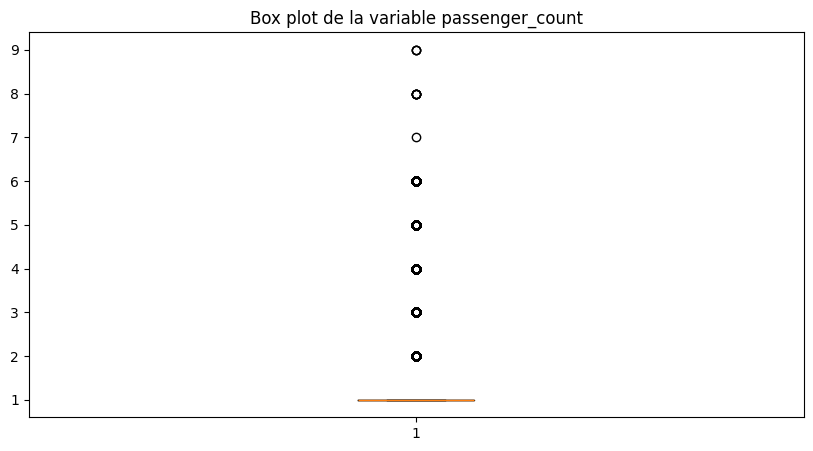

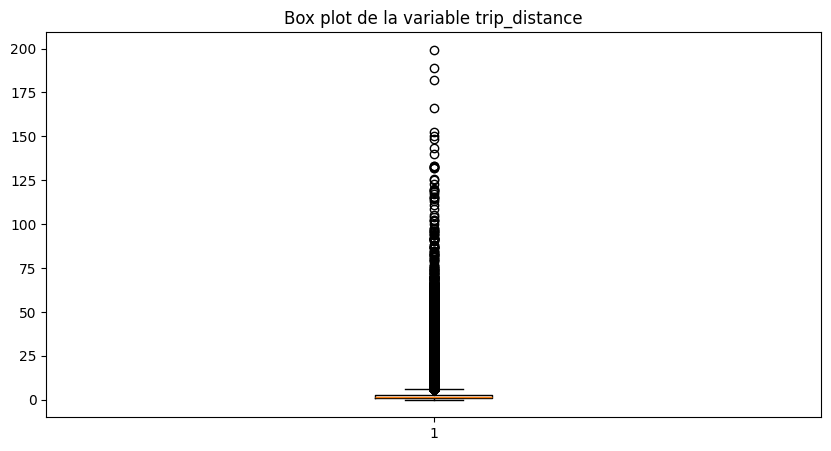

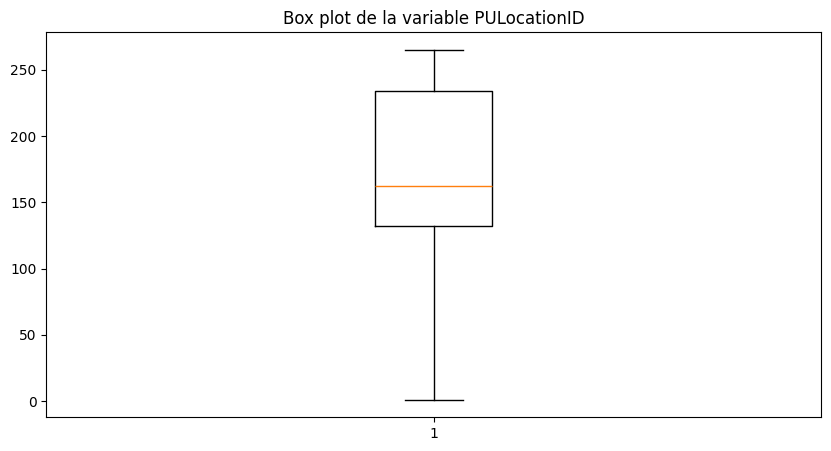

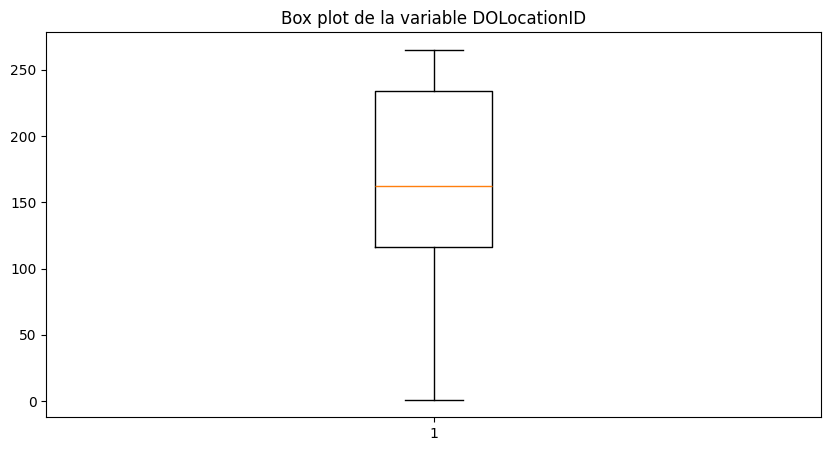

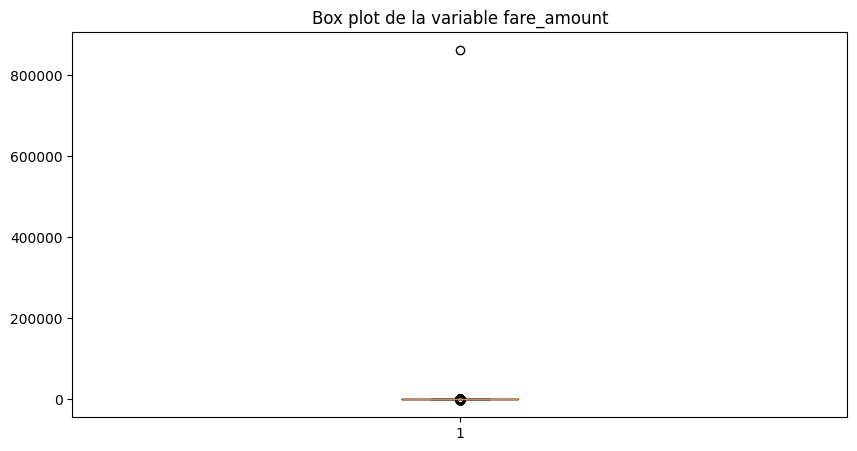

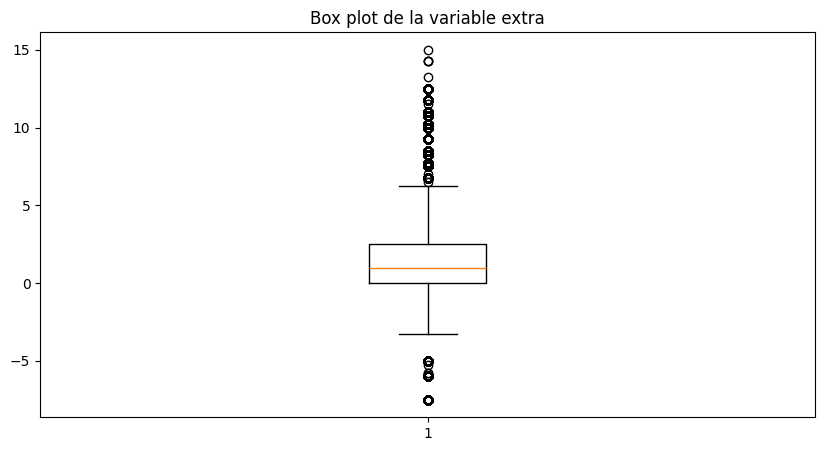

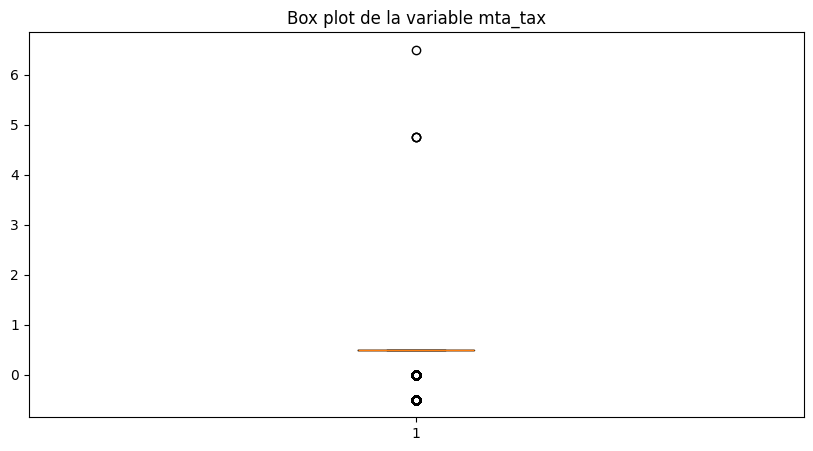

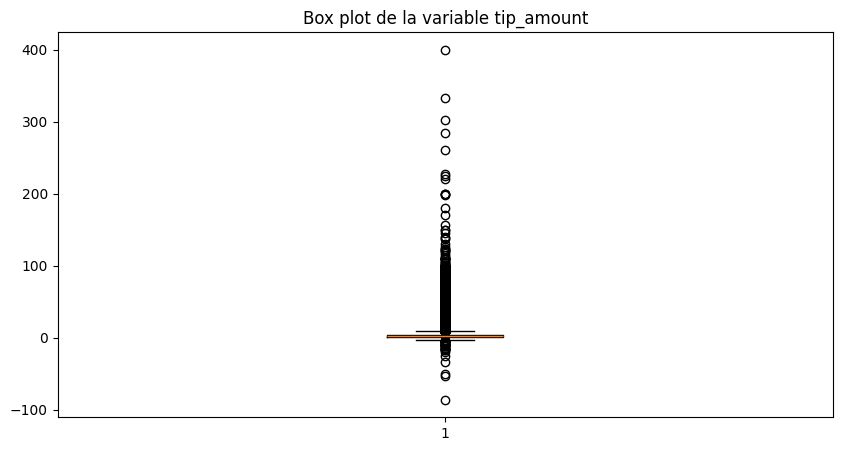

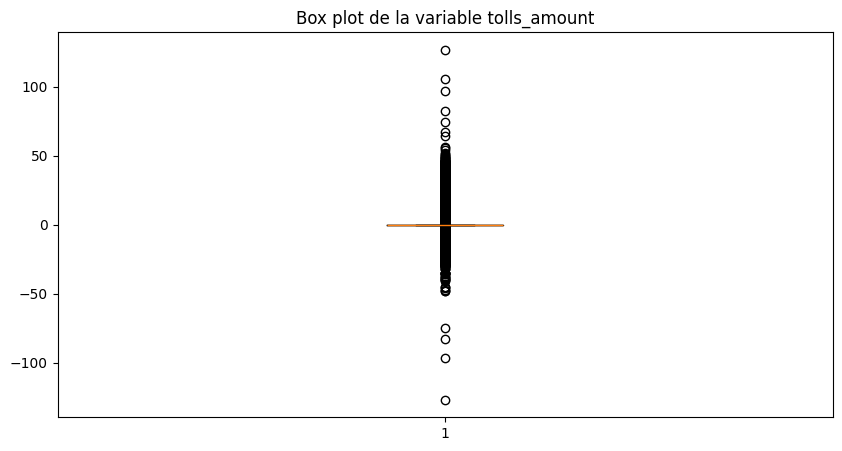

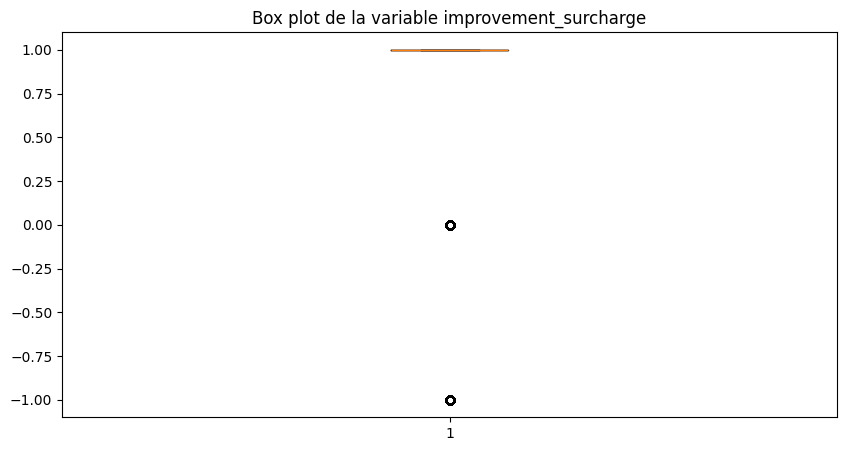

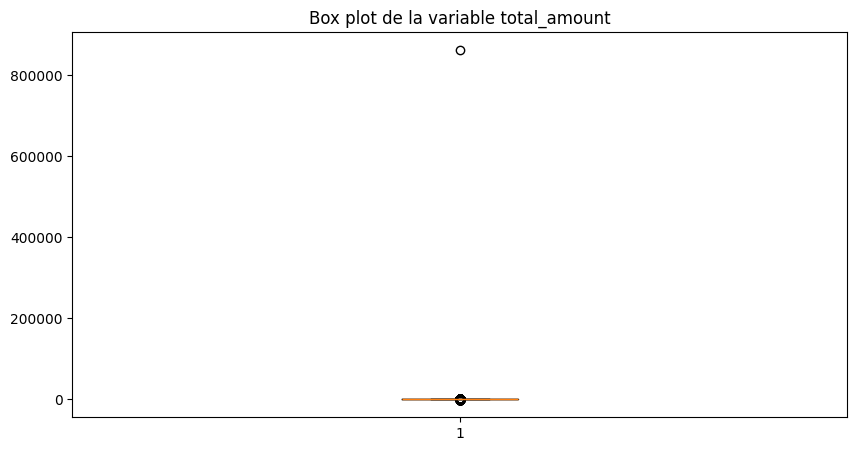

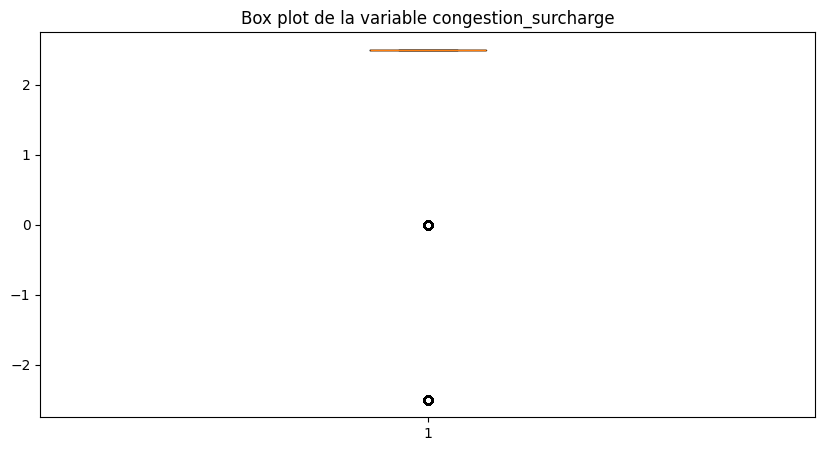

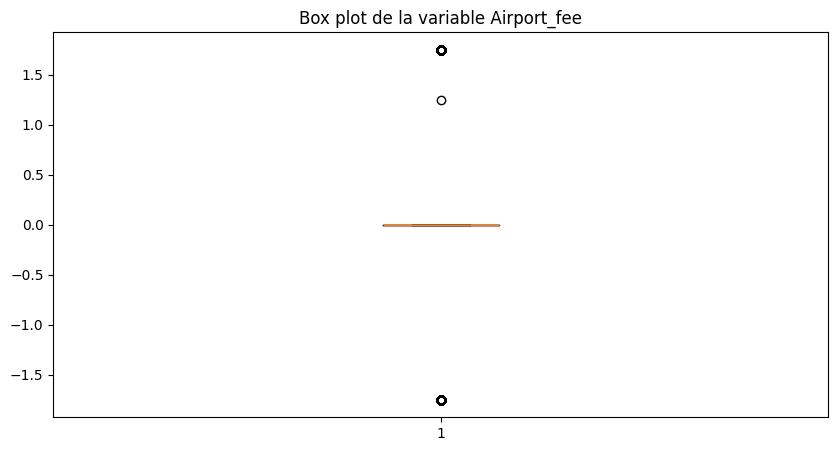

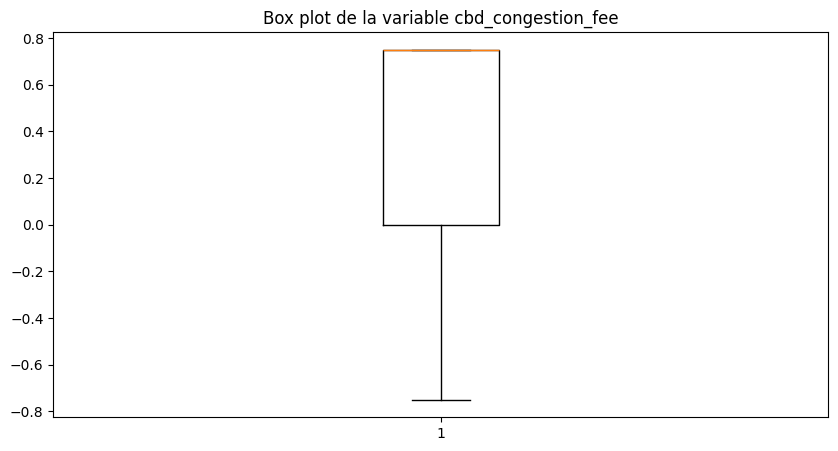

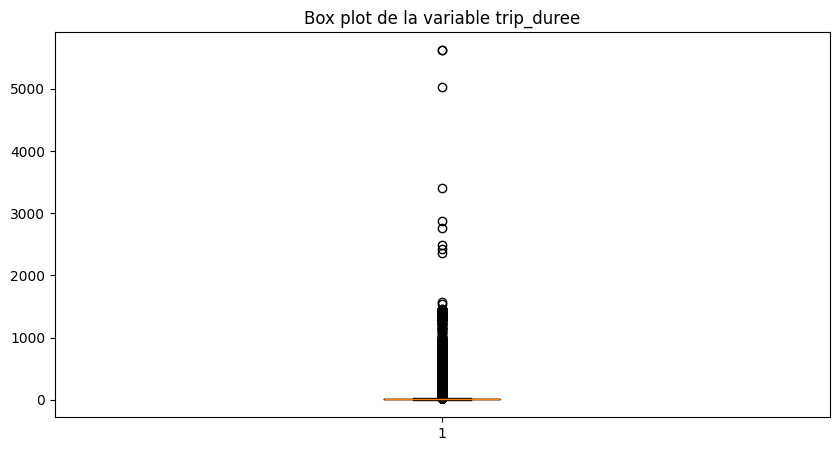

In [39]:
plot_boxplots(silver_df_new, numeric_cols)

#### matrice de correlation 

In [40]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col, stddev
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr_heatmap(df, numeric_cols, variance_threshold=1e-8):
   
    # 1. Remplacer les valeurs null par 0 (optionnel)
    df_clean = df.fillna(0, subset=numeric_cols)
    
    # 2. Sélectionner les colonnes avec variance suffisante
    valid_cols = []
    for c in numeric_cols:
        var_val = df_clean.select(stddev(col(c))).first()[0]
        if var_val is not None and var_val > variance_threshold:
            valid_cols.append(c)
    
    if not valid_cols:
        raise ValueError("Aucune colonne avec variance suffisante pour calculer la corrélation.")
    
    # 3. VectorAssembler pour PySpark
    assembler = VectorAssembler(inputCols=valid_cols, outputCol="features")
    vector_df = assembler.transform(df_clean).select("features")
    
    # 4. Calcul corrélation Pearson
    corr_array = Correlation.corr(vector_df, "features", "pearson").head()[0].toArray()
    
    # 5. Conversion en DataFrame Pandas
    corr_df = pd.DataFrame(corr_array, columns=valid_cols, index=valid_cols)
    
    # 6. Affichage heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Matrice de corrélation Pearson")
    plt.show()
    
    return 


26/01/14 22:08:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


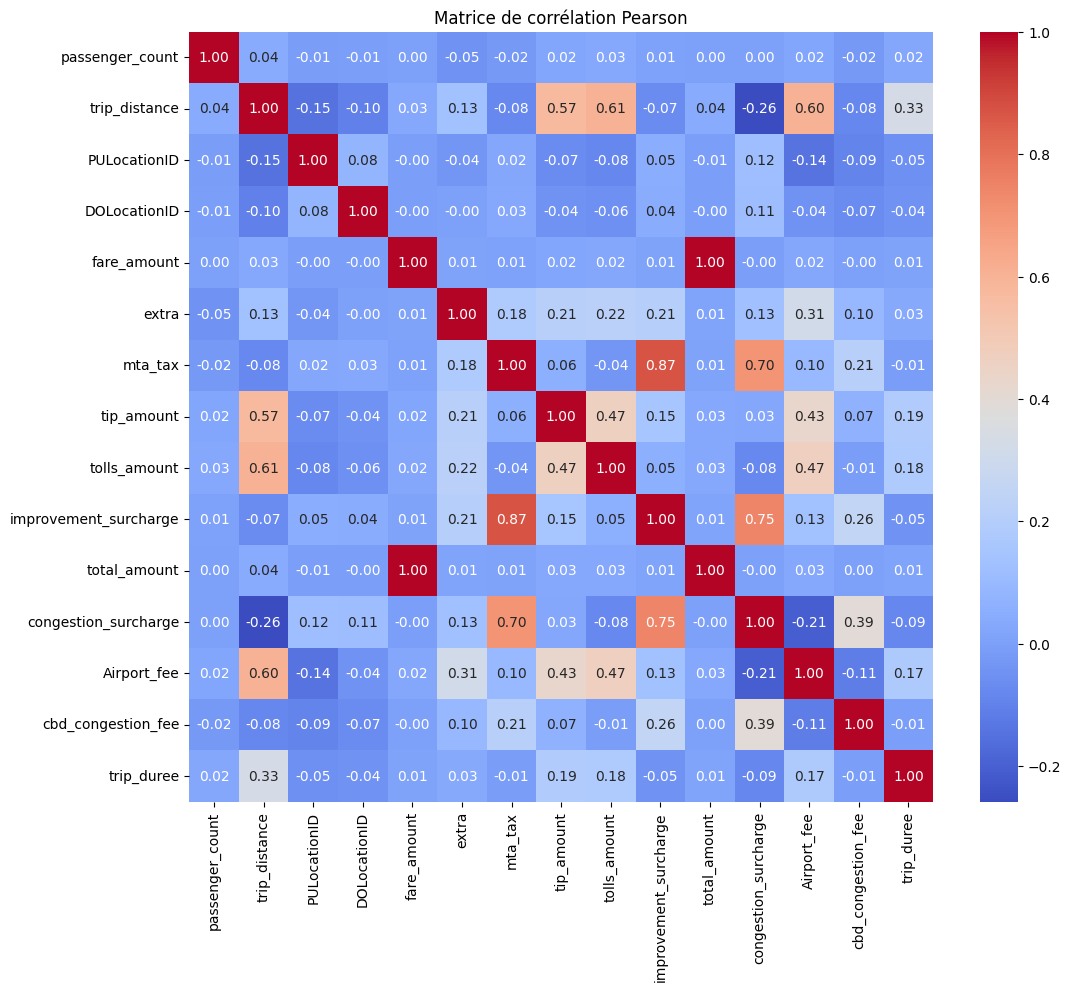

In [41]:
plot_corr_heatmap(silver_df_new, numeric_cols, variance_threshold=1e-8)

#### Traitement (suppression) les outliers 

In [42]:

from pyspark.sql.functions import col, mean, stddev 
silver_df_clean = silver_df_new

for c in numeric_cols:
    stats = silver_df_clean.select(mean(col(c)).alias("mean"),stddev(col(c)).alias("stddev")).collect()[0]
    
    mean_val, std_val = stats["mean"], stats["stddev"]
    
    # Ajouter une colonne Z-score temporaire
    silver_df_clean = silver_df_clean.withColumn(f"z_{c}", (col(c) - mean_val) / std_val)



In [43]:
from pyspark.sql.functions import abs 
for c in numeric_cols:
   silver_df_clean = silver_df_clean.filter(abs(col(f"z_{c}")) <= 3)

In [44]:
silver_df_clean.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+-----------+-----------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-----------------------+--------------------+----------------------+-------------------+--------------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|        trip_duree|pickup_hour|day_of_week|month|   z_

In [45]:
silver_df_clean = silver_df_clean.drop(*[f"z_{c}" for c in numeric_cols])
silver_df_clean.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+-----------+-----------+-----+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|        trip_duree|pickup_hour|day_of_week|month|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+-----------+--

In [46]:
# verification des valeres manquaantes
from pyspark.sql.functions import col, sum, when, isnan,count
silver_df_clean.select([count(when(col(c).isNull(), c)).alias(c) for c in silver_df_clean.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+----------+-----------+-----------+-----+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|trip_duree|pickup_hour|day_of_week|month|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+----------+-----------+-----------+-----+
|      

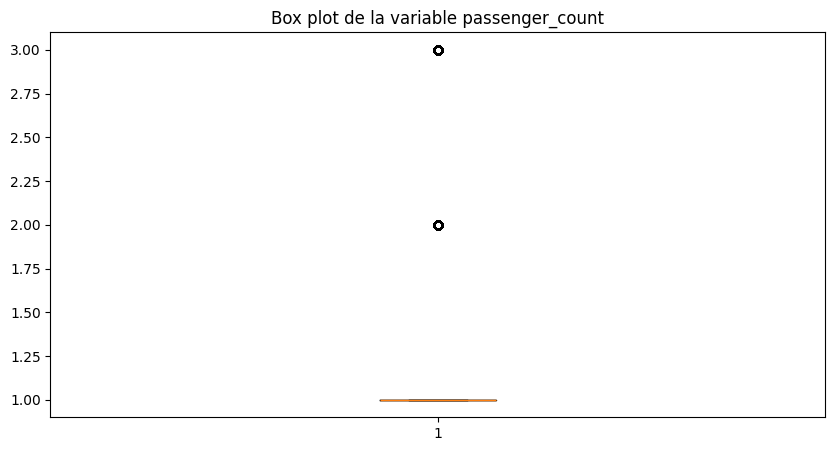

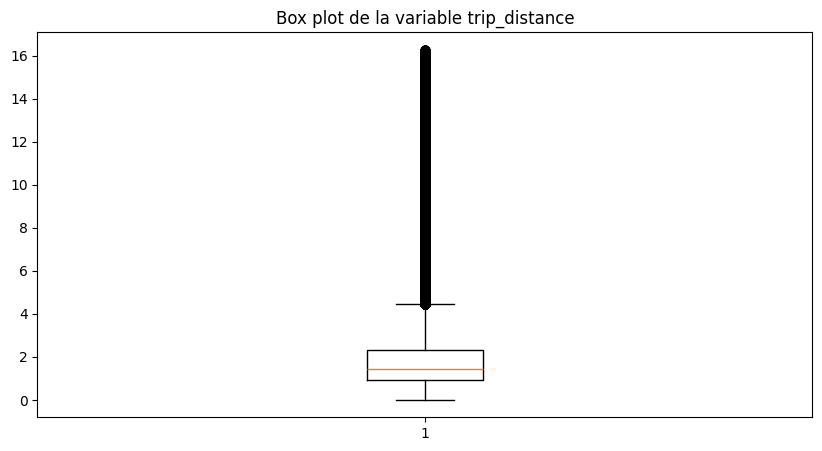

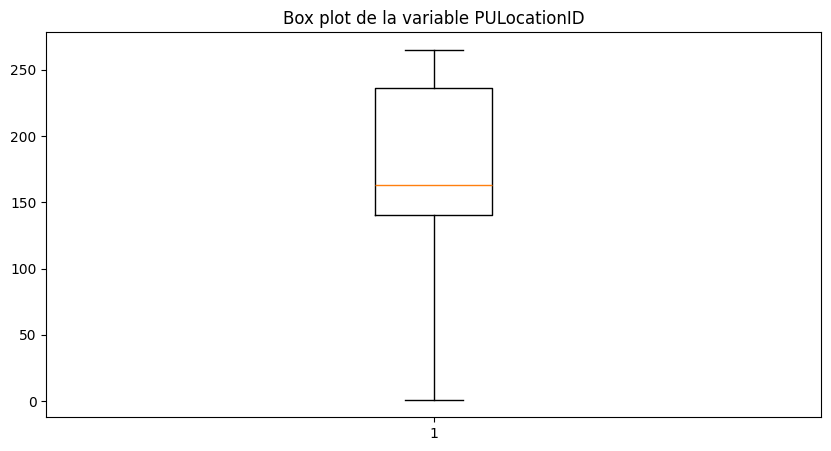

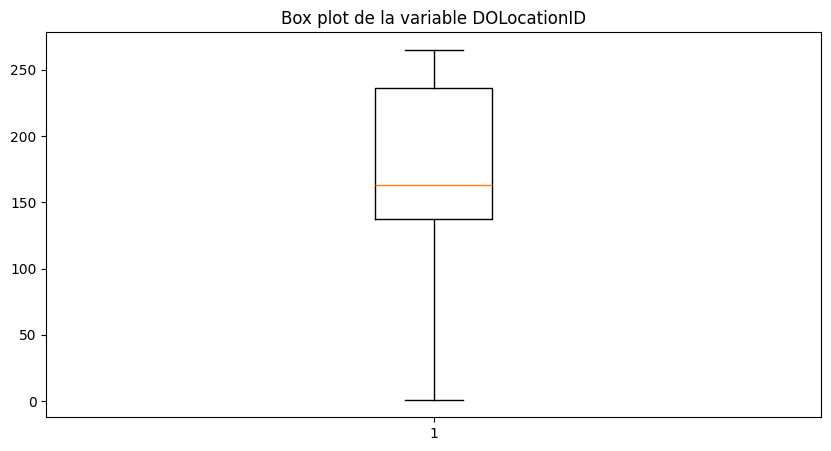

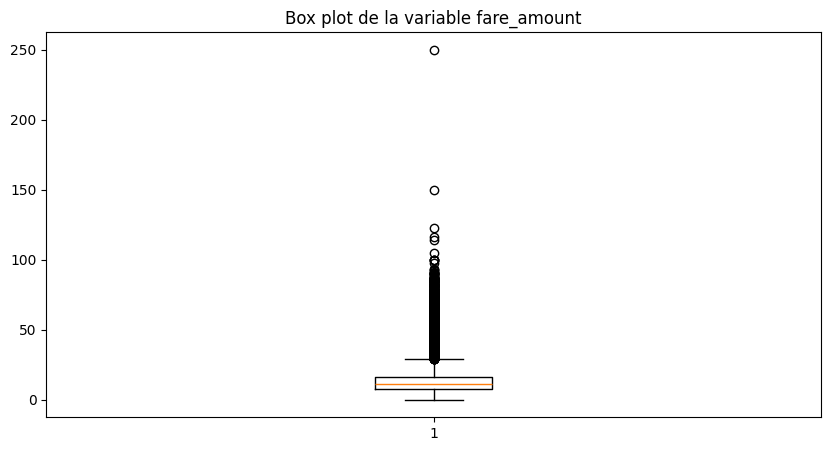

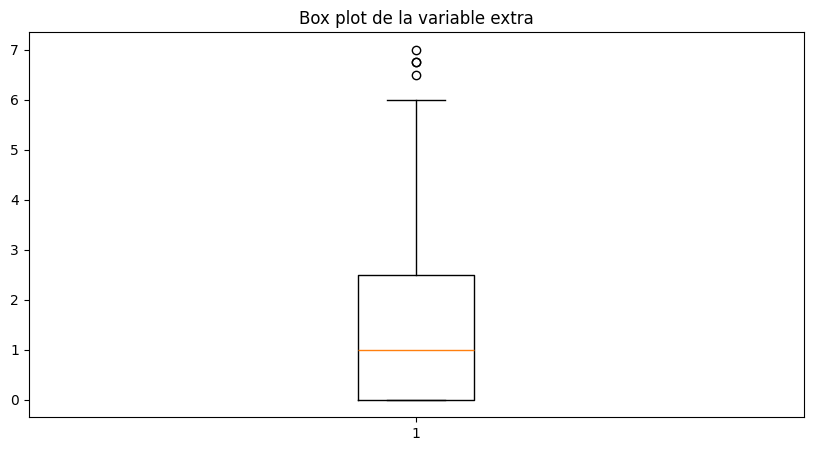

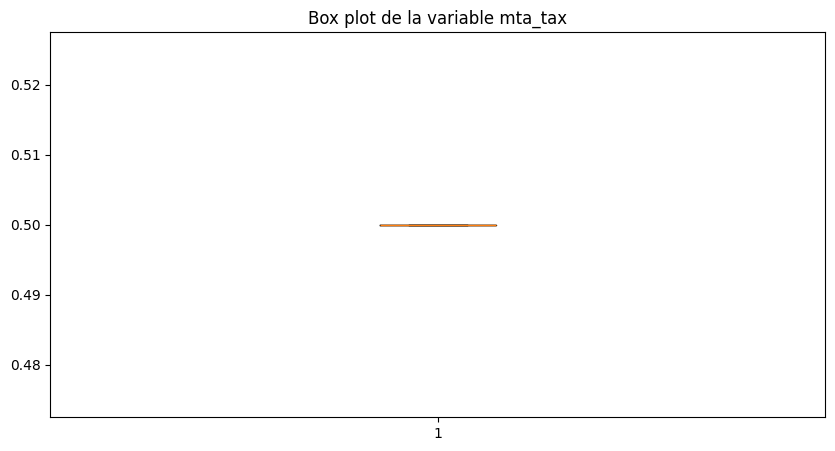

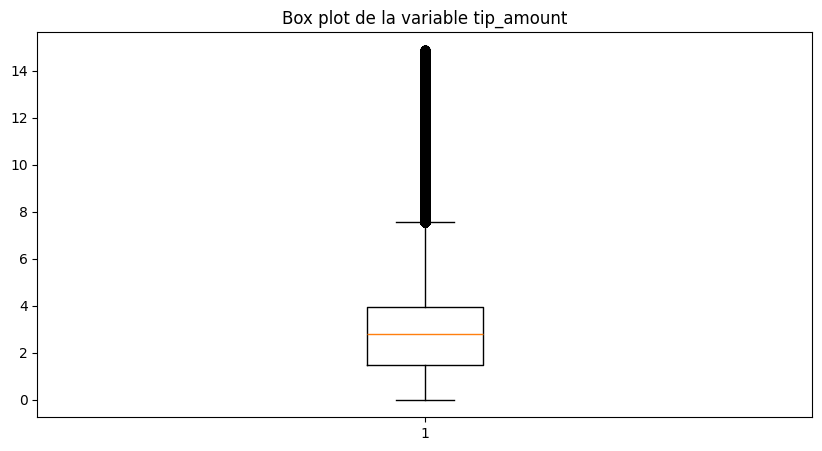

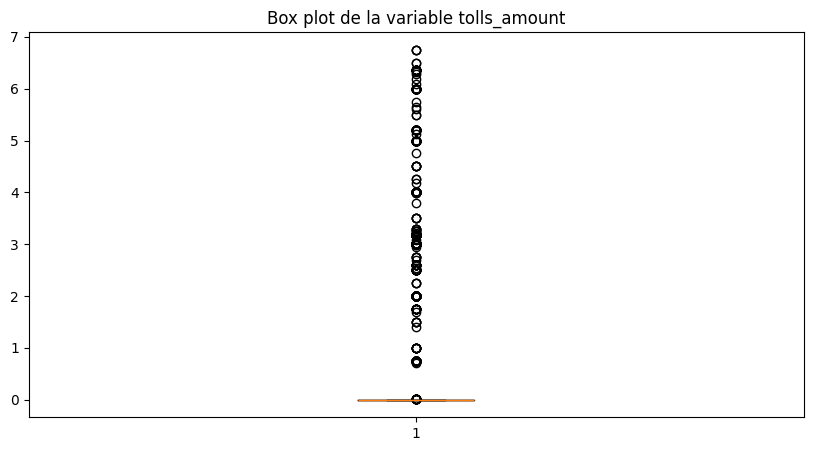

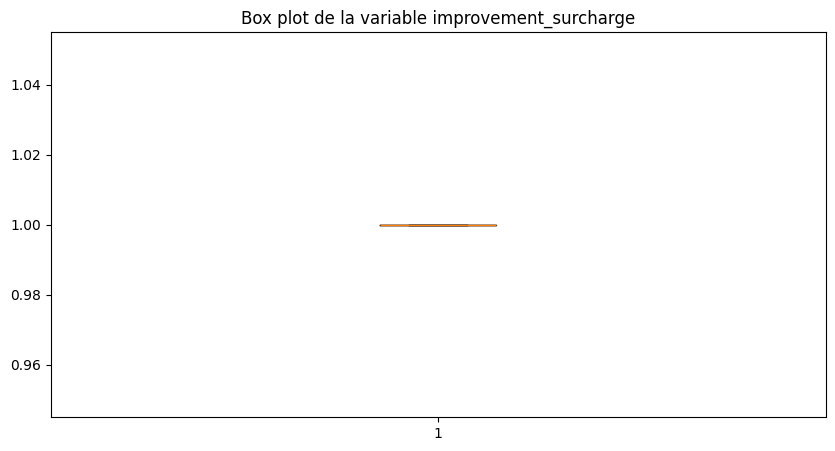

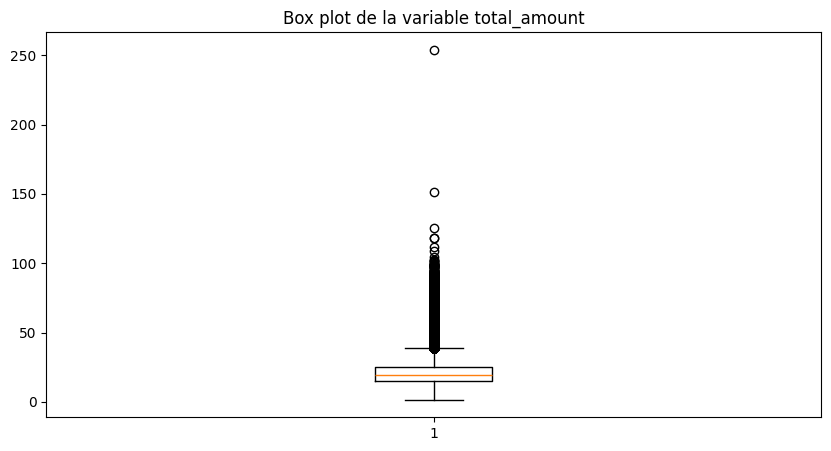

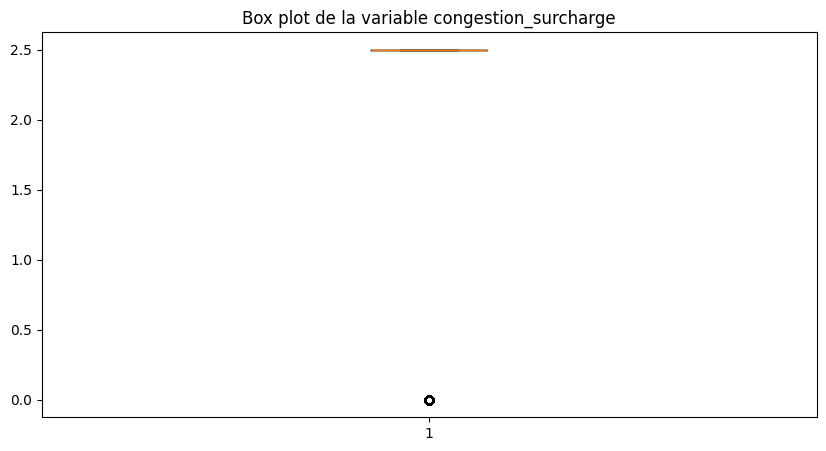

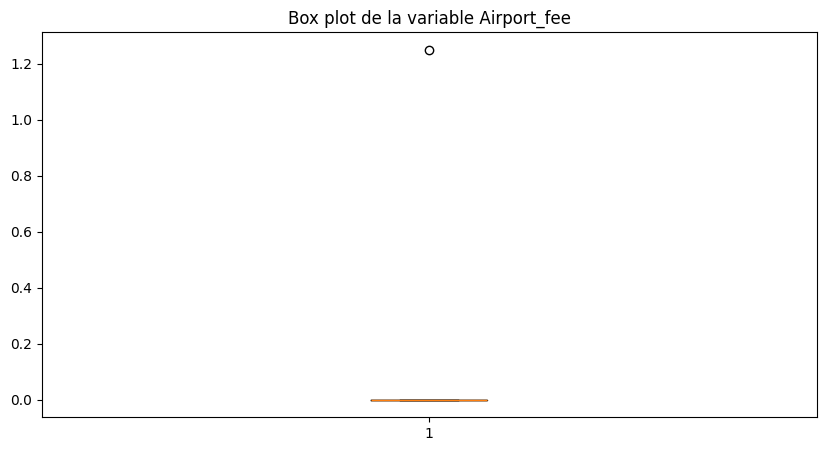

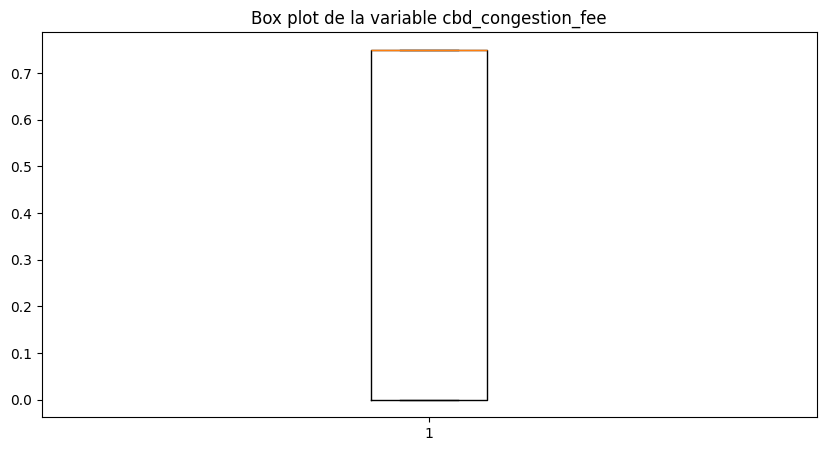

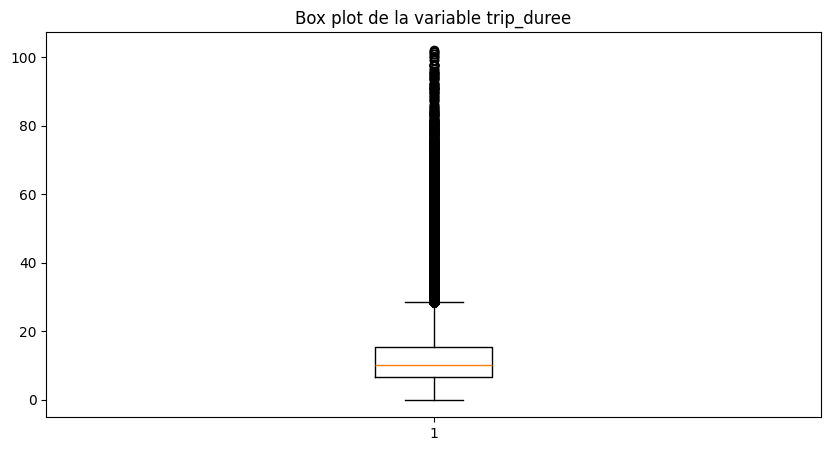

In [47]:
plot_boxplots(silver_df_clean,numeric_cols)

#### Matrice de correlation apres suppression les outilers 

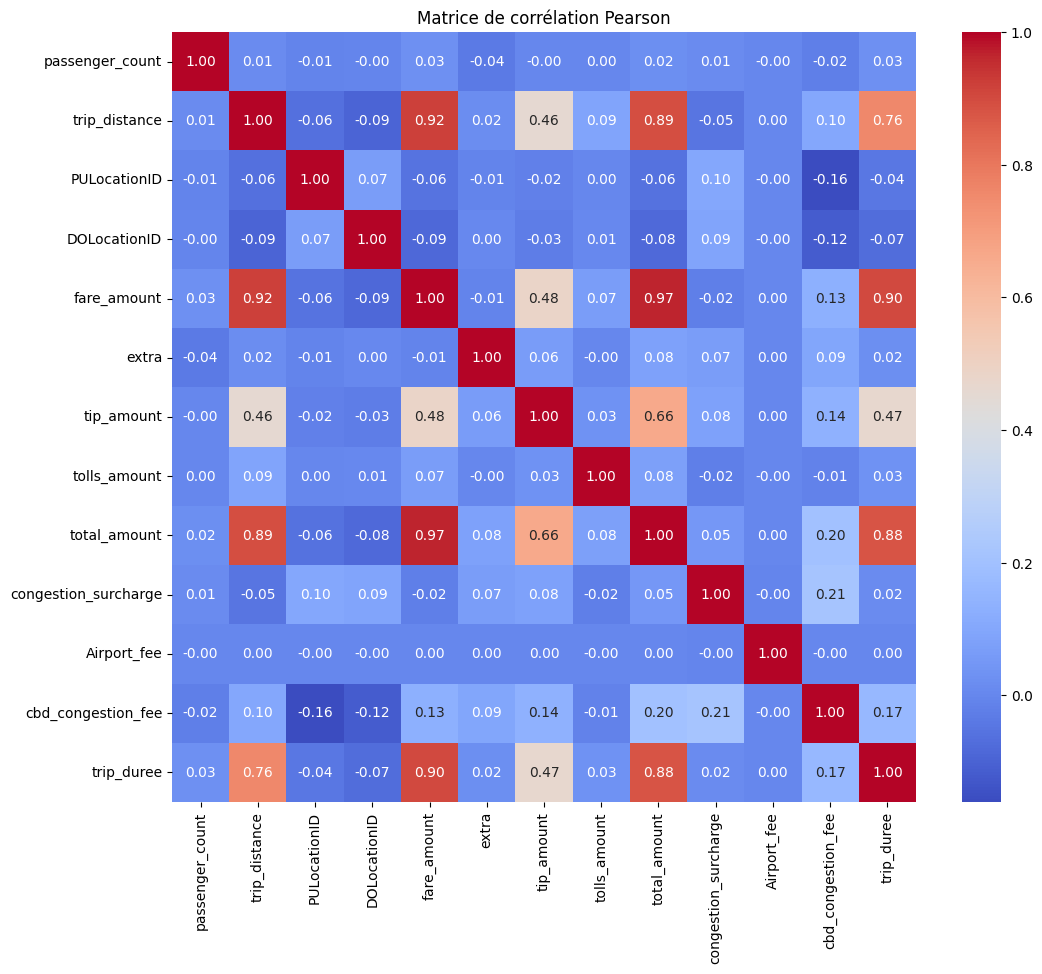

In [48]:
plot_corr_heatmap(silver_df_clean, numeric_cols, variance_threshold=1e-8)

#### Analyse des Features Numériques par rapport à la cible `trip_duree`

- **Features numériques ayant une forte influence sur `trip_duree` :**  
  `["trip_distance", "fare_amount", "total_amount", "tip_amount", "cbd_congestion_fee"]`

- **Features numériques ayant une faible corrélation avec `trip_duree` :**  
  `["passenger_count", "extra", "tolls_amount", "congestion_surcharge", "Airport_fee", "PULocationID", "DOLocationID"]`

- **Features numériques à faible variance (non incluses dans la matrice de corrélation) :**  
  `["mta_tax", "improvement_surcharge"]`


### Relation entre features categoriques et la cible 

In [49]:
silver_df_clean.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)
 |-- trip_duree: double (nullable = true)
 |-- pickup_hour: integer (nullable = true

In [50]:
categorical_cols = [
    "VendorID",
    "RatecodeID",
    "payment_type",
    "store_and_fwd_flag"
]

In [51]:
from pyspark.sql.functions import avg

for c in categorical_cols:
    print(f"--- {c} ---")
    silver_df_clean.groupBy(c).agg(avg("trip_duree").alias("avg_trip_duree")).show()


--- VendorID ---


+--------+------------------+
|VendorID|    avg_trip_duree|
+--------+------------------+
|       1|12.132575372811393|
|       2|11.776899661815472|
+--------+------------------+

--- RatecodeID ---


+----------+------------------+
|RatecodeID|    avg_trip_duree|
+----------+------------------+
|         6|0.1433333333333333|
|         5|10.386348684210525|
|         1|11.835543163465564|
|         2|16.728862275449103|
|         4| 21.62208333333333|
|        99| 30.66332522303323|
+----------+------------------+

--- payment_type ---


+------------+------------------+
|payment_type|    avg_trip_duree|
+------------+------------------+
|           1|11.887138913935214|
|           3|10.411423082346317|
|           2| 11.75683057780812|
|           4|11.085163277880463|
+------------+------------------+

--- store_and_fwd_flag ---


+------------------+------------------+
|store_and_fwd_flag|    avg_trip_duree|
+------------------+------------------+
|                 Y|11.896800825593399|
|                 N|11.855688512405656|
+------------------+------------------+



In [52]:
# Supprimer toutes les lignes où RatecodeID = 99
silver_df_clean = silver_df_clean.filter((silver_df_clean.RatecodeID != 99) & (silver_df_clean.RatecodeID != 6) )

# Vérifier
silver_df_clean.groupBy("RatecodeID").count().orderBy("RatecodeID").show()


+----------+-------+
|RatecodeID|  count|
+----------+-------+
|         1|2401263|
|         2|   1670|
|         4|    240|
|         5|    304|
+----------+-------+



In [53]:
from pyspark.sql.functions import avg

for c in categorical_cols:
    print(f"--- {c} ---")
    silver_df_clean.groupBy(c).agg(avg("trip_duree").alias("avg_trip_duree")).show()

--- VendorID ---


+--------+------------------+
|VendorID|    avg_trip_duree|
+--------+------------------+
|       1|12.062025930455134|
|       2|11.776616262279518|
+--------+------------------+

--- RatecodeID ---


+----------+------------------+
|RatecodeID|    avg_trip_duree|
+----------+------------------+
|         5|10.386348684210525|
|         1|11.835543163465564|
|         2|16.728862275449103|
|         4| 21.62208333333333|
+----------+------------------+

--- payment_type ---


+------------+------------------+
|payment_type|    avg_trip_duree|
+------------+------------------+
|           1|11.868690875206523|
|           3|10.405861716381086|
|           2|11.755541605612944|
|           4|11.083283420219118|
+------------+------------------+

--- store_and_fwd_flag ---


+------------------+------------------+
|store_and_fwd_flag|    avg_trip_duree|
+------------------+------------------+
|                 Y|11.896800825593399|
|                 N| 11.83959103283898|
+------------------+------------------+



#### Analyse des Features Catégorielles par rapport à la cible `trip_duree`

- **RatecodeID :** Influence très forte sur la durée du trajet → **feature clé à conserver**.
- **payment_type :** Impact modéré → **à conserver pour le modèle**.
- **VendorID :** Faible influence → **peut être ignoré**.
- **store_and_fwd_flag :** Effet quasi nul → **inutile pour le modèle**.

**Conclusion :**  
Pour le ML, nous allons **conserver `RatecodeID` et `payment_type`** comme variables catégorielles pertinentes.


### **Conclusion générale :**  
Pour le ML, nous allons **conserver les variables suivantes :**  

- Numériques : `["trip_distance", "fare_amount", "total_amount", "tip_amount", "cbd_congestion_fee"]`  
- Catégorielles : `["RatecodeID", "payment_type"]`

et supprimer les features : `["VendorID","tpep_pickup_datetime","tpep_dropoff_datetime", "store_and_fwd_flag","passenger_count", "extra","tolls_amount","congestion_surcharge","Airport_fee","PULocationID","DOLocationID","mta_tax","improvement_surcharge"]`

In [59]:
cols_to_drop = ["VendorID","tpep_pickup_datetime","tpep_dropoff_datetime", "store_and_fwd_flag","passenger_count", "extra","tolls_amount","congestion_surcharge","Airport_fee","PULocationID","DOLocationID","mta_tax","improvement_surcharge"]
silver_df_clean = silver_df_clean.drop(*cols_to_drop)

In [60]:
silver_df_clean.printSchema()

root
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)
 |-- trip_duree: double (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month: integer (nullable = true)



In [54]:
# Créer la base silver si elle n'existe pas
spark.sql("CREATE DATABASE IF NOT EXISTS silver")

26/01/14 22:12:55 WARN ObjectStore: Failed to get database silver, returning NoSuchObjectException
26/01/14 22:12:55 WARN ObjectStore: Failed to get database silver, returning NoSuchObjectException
26/01/14 22:12:55 WARN ObjectStore: Failed to get database silver, returning NoSuchObjectException


DataFrame[]

In [ ]:
# Stocker le DataFrame nettoyee et enrichis(silver)
silver_df_clean.write.format("parquet").mode("overwrite").saveAsTable("silver.silver_taxi")

In [62]:
# Vérifie que la base bronze existe dans Spark
spark.sql("SHOW DATABASES").show()

# Vérifie que la table bronze_taxi est créée
spark.sql("SHOW TABLES IN silver").show()



+---------+
|namespace|
+---------+
|   bronze|
|  default|
|   silver|
+---------+

+---------+-----------+-----------+
|namespace|  tableName|isTemporary|
+---------+-----------+-----------+
|   silver|silver_taxi|      false|
+---------+-----------+-----------+



In [ ]:
df = spark.table("silver.silver_taxi")
df.show(5)

+-------------+----------+------------+-----------+----------+------------+------------------+------------------+-----------+-----------+-----+
|trip_distance|RatecodeID|payment_type|fare_amount|tip_amount|total_amount|cbd_congestion_fee|        trip_duree|pickup_hour|day_of_week|month|
+-------------+----------+------------+-----------+----------+------------+------------------+------------------+-----------+-----------+-----+
|         1.07|         1|           1|       16.3|      4.21|       25.26|              0.75|19.633333333333333|         18|          1|    1|
|         1.21|         1|           1|        9.3|      2.81|       16.86|              0.75| 8.516666666666667|         18|          1|    1|
|          2.0|         1|           1|       14.2|      3.75|        22.7|              0.75|14.016666666666667|         18|          1|    1|
|          2.3|         1|           1|       14.9|       4.9|       24.55|              0.75|13.666666666666666|         18|          1

In [64]:
df_p =  df.toPandas()

In [66]:
from database import engine 
table_name = "silver_taxi"
df_p.to_sql(table_name, engine, if_exists="replace", index=False)

print(f"Données stockées avec succès dans la table '{table_name}' !")

Données stockées avec succès dans la table 'silver_taxi' !
